## Data Ingestion from the CSV file of the air quality dataset to InfluxDB on AWS EC2

In [316]:
import pandas as pd
import datetime as dt
from numpy import float64
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import the new influxdb API client
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

# Read the csv into a dataframe
df = pd.read_csv("data/PRSA_Data_Wanshouxigong_20130301-20170228.csv")

In [317]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
1,2,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2,3,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
3,4,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
4,5,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


<Figure size 720x432 with 0 Axes>

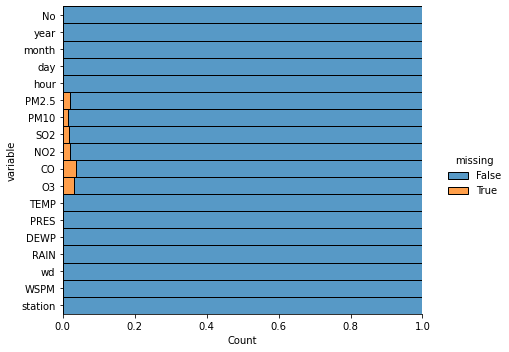

In [318]:
# Identify missing values
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
    )
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)


Text(0.5, 1.0, 'Quantifying missing data')

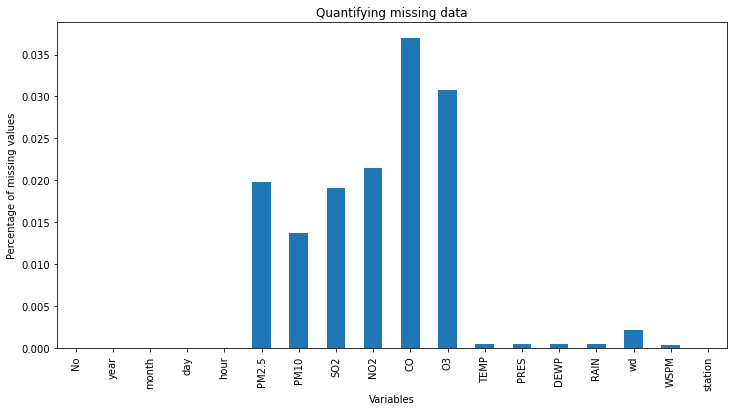

In [319]:
df.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

In [320]:
df.dropna(axis=0, how='any', inplace=True)

Text(0.5, 1.0, 'Quantifying missing data')

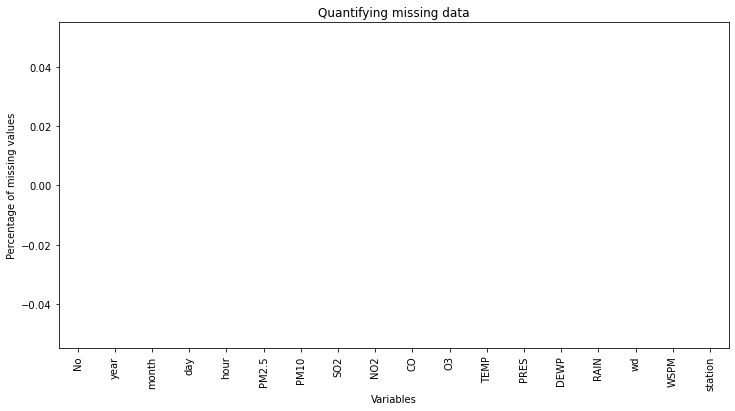

In [321]:
df.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

In [322]:
# As there is no timestamp on the dataset, only 4 separate column
# I am creating a timestamp out of the four columns
# needed for influx 2020-01-01T00:00:00.00Z
# lambda s : dt.datetime(*s) takes every row and convert them -> *s
# strftime to reformat the string into influxdb timestamp format
df['TimeStamp'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda s: dt.datetime(*s).strftime('%Y-%m-%dT%H:%M:%SZ'), axis=1)

In [323]:
time.sleep(10) # Sleep for 10 seconds

In [324]:
# setting the timestamp as the index of the dataframe
df.set_index('TimeStamp', inplace=True)

In [325]:
# dropping the year, month, day, hour, No from the dataframe
converted_ts = df.drop(['year', 'month', 'day', 'hour', 'No'], axis=1)

In [326]:
print(converted_ts)

                      PM2.5  PM10  SO2   NO2     CO    O3  TEMP    PRES  DEWP  \
TimeStamp                                                                       
2013-03-01T00:00:00Z    9.0   9.0  6.0  17.0  200.0  62.0   0.3  1021.9 -19.0   
2013-03-01T01:00:00Z   11.0  11.0  7.0  14.0  200.0  66.0  -0.1  1022.4 -19.3   
2013-03-01T05:00:00Z   10.0  10.0  4.0   8.0  200.0  64.0  -1.6  1024.7 -21.1   
2013-03-01T06:00:00Z    8.0   8.0  6.0  13.0  300.0  61.0  -2.4  1025.4 -20.3   
2013-03-01T07:00:00Z    8.0   8.0  8.0  20.0  300.0  54.0  -0.8  1026.7 -19.9   
...                     ...   ...  ...   ...    ...   ...   ...     ...   ...   
2017-02-28T19:00:00Z   11.0  32.0  3.0  24.0  400.0  72.0  12.5  1013.5 -16.2   
2017-02-28T20:00:00Z   13.0  32.0  3.0  41.0  500.0  50.0  11.6  1013.6 -15.1   
2017-02-28T21:00:00Z   14.0  28.0  4.0  38.0  500.0  54.0  10.8  1014.2 -13.3   
2017-02-28T22:00:00Z   12.0  23.0  4.0  30.0  400.0  59.0  10.5  1014.4 -12.9   
2017-02-28T23:00:00Z   13.0 

In [327]:
# Changing the column types to float
ex_df = converted_ts.astype({"PM2.5": float64,
                             "PM10": float64,
                             "SO2": float64,
                             "NO2": float64,
                             "CO": float64,
                             "O3": float64,
                             "TEMP": float64,
                             "PRES": float64,
                             "DEWP": float64,
                             "RAIN": float64,
                             "WSPM": float64})

In [328]:
# Defining tag fields
datatags = ['station', 'wd']

In [329]:
#Setting up Database (Connection string)
client = influxdb_client.InfluxDBClient(
    url='http://ec2-3-120-10-156.eu-central-1.compute.amazonaws.com:8086',
    token='kp_gJV8Y7aOZB0odriHj1o_qWurQmxzBXpTU_kYY4JnQ88e9X1TI3ifFVA1pUyGZshZfTpeaTlTWgYAUESTMvw==',
    org='my-org'
)

In [330]:
# Writing the data with two tags
write_api = client.write_api(write_options=SYNCHRONOUS)
message = write_api.write(bucket='air-quality', org='my-org', record=ex_df,
data_frame_measurement_name='full-tags', data_frame_tag_columns=['station', 'wd'])
print(message)

None


In [331]:
time.sleep(10) # Sleep for 10 seconds

In [332]:
# The asynchronous buffering API to Write time-series data into InfluxDB.
# This API always buffers points/lines to create batches under the hood to optimize data 
# transfer to InfluxDB server, flush is used to send the buffered data to InfluxDB immediately.
# I use flush() after each write as I was getting a "time out error message"
write_api.flush()

In [333]:
# Writing the data only with one tag
write_api = client.write_api(write_options=SYNCHRONOUS)
message = write_api.write(bucket='air-quality', org='my-org', record=ex_df,
data_frame_measurement_name='location-tag-only', data_frame_tag_columns=['station'])
print('Errors detected writing data to InfluxDB: ', message)

Errors detected writing data to InfluxDB:  None


In [334]:
time.sleep(10) # Sleep for 10 seconds

In [335]:
write_api.flush()